<h1 style="text-align: center; color: #6A5ACD;">
Más Allá de la Predicción: Simulaciones para Entender el Abandono en Salud Mental
</h1>

<h2 style="color: #6A5ACD;">
Análisis de Clusters y Perfiles de Usuario
</h2>

<h2 style="color: #6A5ACD;">
1. Configuración y librerías necesarias
</h2>

In [1]:
# Librerías

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuración general

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Carpetas de salida

os.makedirs("out", exist_ok=True)
os.makedirs("fig", exist_ok=True)

# Función utilitaria para guardar figuras

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show()


<h2 style="color: #6A5ACD;">
2. Carga de datos
</h2>

In [2]:
DATA_PATH = "Data/mental_health_data_cohortes.csv"  
df = pd.read_csv(DATA_PATH)

# Resumen inicial
n_rows, n_cols = df.shape
print(f"Registros: {n_rows:,} | Columnas: {n_cols}")
display(df.head(3))
display(df.info())

Registros: 50,000 | Columnas: 26


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage,churn,Age_group,Sleep_group,Work_group,PA_group,SM_group,Severity_filled,work_sleep_ratio,lifestyle_risk
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes,0,30-44,7-9h,41-55,5-8h,1-3h,Unknown,0.864662,0
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No,0,45-59,5-7h,>70,<2h,3-5h,Low,1.554622,1
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No,0,18-29,7-9h,>70,>8h,>5h,Unknown,1.549296,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 24998 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  object 
 9   Sleep_Hours              50000 non-null  float64
 10  Work_Hours               50000 non-null  int64  
 11  Physical_Activity_Hours  50000 non-null  int64  
 12  Social_Media_Usage       50000 non-null  float64
 13  Diet_Quality             50000 non-null  object 
 14  Smoking_Habit         

None

<h2 style="color: #6A5ACD;">
3. Selección de variables y preprocesamiento<
</h2>

No usar churn para entrenar el clustering (solo para perfilar).

-  Numéricas (continuas): Sleep_Hours, Work_Hours, Physical_Activity_Hours, Social_Media_Usage, work_sleep_ratio, lifestyle_risk.

-  Categóricas (cohortes): Age_group, Gender, Country, Stress_Level, Severity_filled, Sleep_group, Work_group, PA_group, SM_group, Mental_Health_Condition.

In [3]:
# Selección de variables y preprocesamiento
num_features = [
    'Age','Sleep_Hours','Work_Hours',
    'Physical_Activity_Hours','Social_Media_Usage',
    'work_sleep_ratio','lifestyle_risk'
]

cat_features = ['Gender','Country','Stress_Level','Severity_filled']

# Filtra filas completas en estas columnas (si hiciera falta)
X = df[num_features + cat_features].copy()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ],
    remainder='drop'
)

X_prepared = preprocessor.fit_transform(X)
print("Shape preprocesada:", X_prepared.shape)


Shape preprocesada: (50000, 25)


Para el análisis de clustering, hemos preparado los datos de la siguiente forma:

- **Variables numéricas**:  
  - `Age`, `Sleep_Hours`, `Work_Hours`, `Physical_Activity_Hours`,  
    `Social_Media_Usage`, `work_sleep_ratio`, `lifestyle_risk`.  
  - Se aplicó **escalado estándar (StandardScaler)** para que todas queden en la misma escala.

- **Variables categóricas**:  
  - `Gender`, `Country`, `Stress_Level`, `Severity_filled`.  
  - Se aplicó **codificación one-hot (OneHotEncoder)** para transformar categorías en variables binarias.  
  - Se configuró `handle_unknown="ignore"` para evitar errores con categorías no vistas.

El resultado es una **matriz preprocesada** lista para aplicar clustering, donde todas las variables están en formato numérico y en escalas comparables.


<h2 style="color: #6A5ACD;">
4. Determinación del número de cluster (Elbow + Silhouette)
</h2>

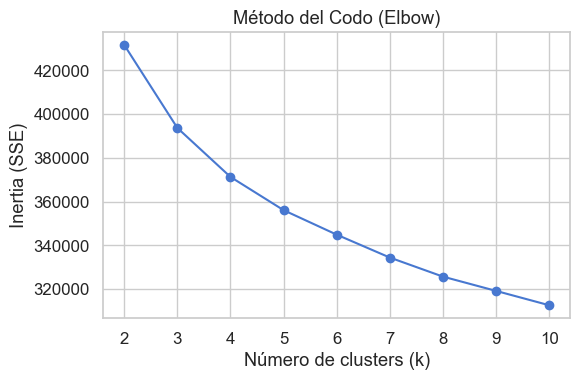

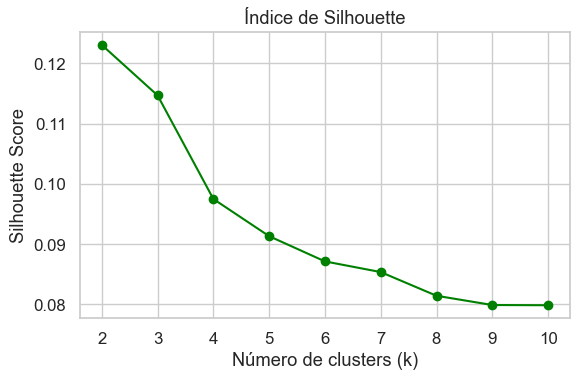

In [4]:
# Inicialización de listas para almacenar métricas
inertia = []
silhouette = []
K_range = range(2, 11)  # probamos entre 2 y 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_prepared)
    
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_prepared, labels))

# Elbow method (Inertia)
plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Método del Codo (Elbow)")
plt.tight_layout()
plt.savefig("fig/elbow_kmeans.png", dpi=150)
plt.show()

# Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(K_range, silhouette, marker="o", color="green")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Índice de Silhouette")
plt.tight_layout()
plt.savefig("fig/silhouette_kmeans.png", dpi=150)
plt.show()


#### Método del Codo (Elbow Method)
- La curva muestra una **caída pronunciada de la inercia** entre `k=2` y `k=4`.
- A partir de `k=5`, la reducción de la inercia se vuelve **mucho más suave**, lo que sugiere que el "codo" de la curva se encuentra alrededor de **`k=4`**.
- `k=4` clusters podrían ser un número razonable para capturar la estructura principal de los datos sin añadir complejidad innecesaria (sobreajuste).

#### Índice de Silhouette
- El **valor más alto** del coeficiente de silueta se obtiene con **`k=2`**. Esto indica que, según esta métrica, 2 clusters logran la mayor cohesión interna y separación entre clusters.
- La métrica **disminuye consistentemente** a medida que `k` aumenta, lo que implica que añadir más clusters reduce la calidad relativa de la separación.
- **Nota importante:** El **valor absoluto** del índice es bajo (<0.15), lo que refleja que, en general, los clusters no son muy compactos ni están bien separados, incluso en el mejor caso.

- **Elbow Method** sugiere **`k=4`** como un punto óptimo que balancea la simplicidad del modelo con la reducción de la varianza intra-cluster.
- **Silhouette** sugiere **`k=2`**, pero el bajo valor absoluto del coeficiente advierte que la separación natural de los datos es débil.

Dada la discrepancia y el contexto exploratorio, tiene sentido **probar ambos valores (`k=2` y `k=4`)** en la fase de modelado y perfilado. La elección final debe basarse en:
1.  La **interpretabilidad** de los clusters resultantes.
2.  La **utilidad** de los segmentos para el análisis de negocio.
3.  La **relación con la variable objetivo** (e.g., tasa de churn por cluster).

<h2 style="color: #6A5ACD;">
5. Modelado y Perfilado de Clusters: K-Means para k=2 y k=4
</h2>

[k2] silhouette = 0.1231


C:\Users\acbon\AppData\Local\Temp\ipykernel_30316\3022229730.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_tbl, x=col_name, y="churn_pct", edgecolor="black", palette="Set2")


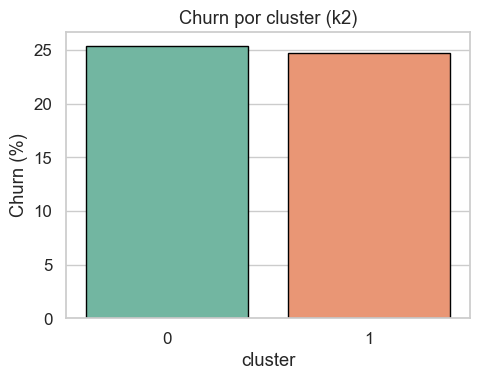

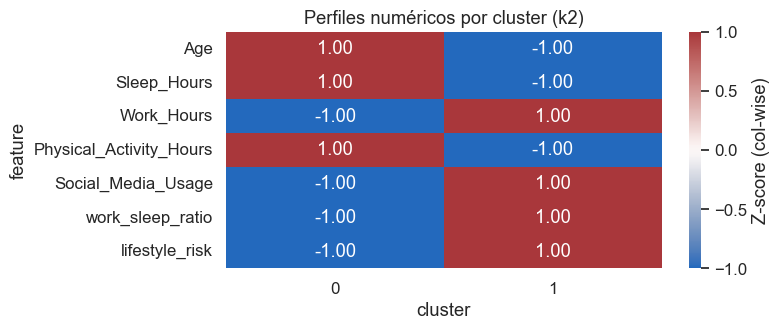

[k4] silhouette = 0.0975


C:\Users\acbon\AppData\Local\Temp\ipykernel_30316\3022229730.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_tbl, x=col_name, y="churn_pct", edgecolor="black", palette="Set2")


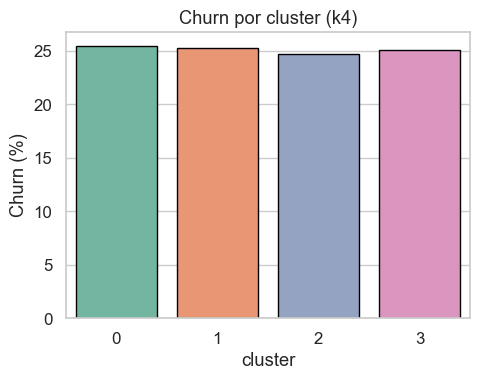

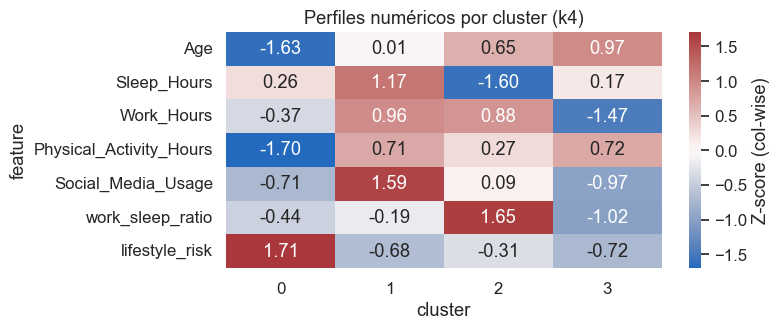

Guardado: out/mental_health_data_clusters_k2_k4.csv


In [5]:
# Función para ajustar KMeans, asignar etiquetas y generar perfiles
def fit_kmeans_and_profile(X_prepared, k, df_original, num_feats, cat_feats, churn_col="churn", prefix=None):
    if prefix is None:
        prefix = f"k{k}"
    col_name = f"cluster_{prefix}"

    # Ajuste y etiquetas
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_prepared)

    # Construir df de salida (idempotente)
    df_out = df_original.copy()
    if col_name in df_out.columns:
        df_out = df_out.drop(columns=[col_name])
    df_out[col_name] = labels

    # Silhouette
    sil = silhouette_score(X_prepared, labels)
    print(f"[{prefix}] silhouette = {sil:.4f}")

    # Perfiles numéricos
    prof_num = df_out.groupby(col_name)[num_feats].mean().reset_index()
    prof_num.to_csv(f"out/{prefix}_profiles_numeric.csv", index=False)

    # Perfiles categóricos (top-3 por cluster y variable) — versión segura
    def cat_props(df, cols, by):
        frames = []
        for c in cols:
            t = (
                df.groupby(by)[c]
                  .value_counts(normalize=True)  # proporciones
                  .rename("prop")
                  .reset_index()
            )
            # top-3 por cluster
            t["rank"] = t.groupby(by)["prop"].rank(method="first", ascending=False)
            frames.append(t.query("rank <= 3").drop(columns="rank"))
        return pd.concat(frames, axis=0, ignore_index=True)

    prof_cat = cat_props(df_out, cat_feats, by=col_name)
    prof_cat.to_csv(f"out/{prefix}_profiles_categorical_top3.csv", index=False)

    # Churn por cluster
    churn_tbl = (
        df_out.groupby(col_name)[churn_col]
              .agg(n="count", churn_1="sum", rate="mean")
              .reset_index()
    )
    churn_tbl["churn_pct"] = 100 * churn_tbl["rate"]
    churn_tbl.to_csv(f"out/{prefix}_churn_by_cluster.csv", index=False)

    # Gráficos
    plt.figure(figsize=(5,4))
    sns.barplot(data=churn_tbl, x=col_name, y="churn_pct", edgecolor="black", palette="Set2")
    plt.ylabel("Churn (%)"); plt.xlabel("cluster")
    plt.title(f"Churn por cluster ({prefix})")
    savefig(f"fig/{prefix}_churn_bar.png")

    num_means = df_out.groupby(col_name)[num_feats].mean()
    num_means_z = (num_means - num_means.mean()) / (num_means.std(ddof=0) + 1e-9)
    plt.figure(figsize=(8, max(3, 0.5*len(num_feats))))
    sns.heatmap(num_means_z.T, annot=True, fmt=".2f", cmap="vlag", center=0,
                cbar_kws={"label":"Z-score (col-wise)"})
    plt.title(f"Perfiles numéricos por cluster ({prefix})")
    plt.xlabel("cluster"); plt.ylabel("feature")
    savefig(f"fig/{prefix}_heatmap_numeric.png")

    return df_out, {"silhouette": sil,
                    "profiles_numeric": prof_num,
                    "profiles_categorical_top3": prof_cat,
                    "churn_by_cluster": churn_tbl}

# Ejecutar para k=2 y k=4 (seguro de re-ejecución) 
num_feats = ['Age','Sleep_Hours','Work_Hours','Physical_Activity_Hours',
             'Social_Media_Usage','work_sleep_ratio','lifestyle_risk']
cat_feats = ['Gender','Country','Stress_Level','Severity_filled']

df_k2, res_k2 = fit_kmeans_and_profile(X_prepared, k=2, df_original=df,
                                       num_feats=num_feats, cat_feats=cat_feats, prefix="k2")

df_k4, res_k4 = fit_kmeans_and_profile(X_prepared, k=4, df_original=df_k2,
                                       num_feats=num_feats, cat_feats=cat_feats, prefix="k4")

df_k4.to_csv("out/mental_health_data_clusters_k2_k4.csv", index=False)
print("Guardado: out/mental_health_data_clusters_k2_k4.csv")


<h2 style="color: #6A5ACD;">
6. Exportación de perfiles de clusters
</h2>

In [7]:
# Consolidar perfiles de k=2 y k=4 en formato tidy
def consolidate_one(res_dict, k_label, cluster_col):
    # --- tablas base del k ---
    num = res_dict["profiles_numeric"].copy()            # columnas: cluster_col, num_feats...
    cat = res_dict["profiles_categorical_top3"].copy()   # columnas: cluster_col, <catvar>, prop
    churn = res_dict["churn_by_cluster"][[cluster_col, "churn_pct"]].copy()

    # NUMÉRICAS → tidy
    num_long = num.melt(id_vars=[cluster_col], var_name="feature", value_name="value")
    num_long["k"] = k_label
    num_long["cluster"] = num_long[cluster_col]
    num_long["kind"] = "numeric"
    num_long["category"] = pd.NA
    num_long = num_long[["k","cluster","kind","feature","category","value"]]

    # CATEGÓRICAS (top-3 por cluster) → tidy
    # detectar la columna del nombre de la variable categórica (la que no es cluster_col ni "prop")
    cat_var_cols = [c for c in cat.columns if c not in [cluster_col, "prop"]]
    # cada fila solo tiene una var categórica "activa"
    cat = cat.melt(id_vars=[cluster_col, "prop"], value_vars=cat_var_cols,
                   var_name="feature", value_name="category").dropna(subset=["category"])
    cat["k"] = k_label
    cat["cluster"] = cat[cluster_col]
    cat["kind"] = "categorical"
    cat = cat.rename(columns={"prop":"value"})
    cat = cat[["k","cluster","kind","feature","category","value"]]

    # añadir churn_pct a ambos
    num_long = num_long.merge(churn, left_on="cluster", right_on=cluster_col, how="left").drop(columns=[cluster_col])
    cat = cat.merge(churn, left_on="cluster", right_on=cluster_col, how="left").drop(columns=[cluster_col])

    return pd.concat([num_long, cat], ignore_index=True)

# Construir k2 y k4
k2_cons = consolidate_one(res_k2, "k2", "cluster_k2")
k4_cons = consolidate_one(res_k4, "k4", "cluster_k4")

# Unir y guardar
profiles_all = pd.concat([k2_cons, k4_cons], ignore_index=True)
profiles_all.to_csv("out/cluster_profiles.csv", index=False)

print("Consolidado exportado a: out/cluster_profiles.csv")
print("Filas:", len(profiles_all))
print(profiles_all.head(10))


Consolidado exportado a: out/cluster_profiles.csv
Filas: 114
    k  cluster     kind                  feature category      value  \
0  k2        0  numeric                      Age     <NA>  41.531180   
1  k2        1  numeric                      Age     <NA>  41.385675   
2  k2        0  numeric              Sleep_Hours     <NA>   7.849432   
3  k2        1  numeric              Sleep_Hours     <NA>   5.747007   
4  k2        0  numeric               Work_Hours     <NA>  48.475079   
5  k2        1  numeric               Work_Hours     <NA>  64.973403   
6  k2        0  numeric  Physical_Activity_Hours     <NA>   5.003563   
7  k2        1  numeric  Physical_Activity_Hours     <NA>   4.949662   
8  k2        0  numeric       Social_Media_Usage     <NA>   3.225057   
9  k2        1  numeric       Social_Media_Usage     <NA>   3.270393   

   churn_pct  
0  25.407025  
1  24.688204  
2  25.407025  
3  24.688204  
4  25.407025  
5  24.688204  
6  25.407025  
7  24.688204  
8  25.40702

Se generaron dos macro-segmentos con perfiles claramente opuestos:

-   **Cluster 0**: Agrupa individuos más **jóvenes**, con **más horas de sueño**, **mayor actividad física** y **menor riesgo en hábitos**.
-   **Cluster 1**: Agrupa individuos de **más edad**, con **menos sueño**, **menos actividad física**, **mayor tiempo en redes sociales** y **mayor riesgo en hábitos**.

**Hallazgo clave en Churn**:
-   Las tasas de churn son **prácticamente iguales** en ambos clusters (~25%).
-   Esto indica que, aunque los perfiles son distintos, **no existe una separación clara en la propensión al abandono**.

#### **Análisis para k=4 Clusters**
El modelo con 4 clusters permite un perfilado más granular y matizado:

-   **Cluster 0**: Jóvenes con **bajo riesgo** pero **menos actividad física**.
-   **Cluster 1**: Perfiles con **más horas de sueño** y **alto uso de redes sociales**.
-   **Cluster 2**: Personas con **más carga laboral** y **menos sueño**.
-   **Cluster 3**: Personas **mayores** con **hábitos de riesgo moderados**.

### **Hallazgo clave en Churn**:
-   Nuevamente, la tasa de churn **oscila alrededor del 25%** en todos los clusters.
-   Esto confirma que los clusters **sirven para describir estilos de vida**, pero **no para discriminar o predecir el abandono**.


#### **Validación del Modelo**
-   Los métodos de validación (**Método del Codo + Índice de Silhouette**) sugirieron que entre 2 y 4 clusters eran opciones razonables.
-   Sin embargo, el **bajo valor del coeficiente de Silhouette (<0.15)** indica que los clusters no son muy compactos ni están bien separados.

#### **Utilidad de los Segmentos**
-   Los perfiles identificados son **útiles para caracterizar estilos de vida y niveles de riesgo** de la base de clientes.
-   **No son útiles para predecir churn**, ya que no logran capturar diferencias significativas en la tasa de abandono.

Estos resultados refuerzan la decisión de:
1.  **Abandonar el enfoque predictivo del churn** con estas variables, al no ser viable con este dataset.
2.  **Aprovechar los clusters** como variables descriptivas de perfil de usuario.
3.  **Utilizar estos segmentos** en los siguientes pasos del análisis:
    - **Notebook 3**: Modelo Logit explicativo para entender drivers.
    - **Notebook 4**: Diseño de experimentos A/B segmentados por estilo de vida.